In [2]:
from typing import Literal
from matplotlib import pyplot as plt
import numpy as np
import torch
from sklearn import metrics

from seisbench.models import PhaseNet
import pandas as pd
import scikitplot as skplt
sampling_rate = 100.0
pn = PhaseNet.from_pretrained("original")


waveform_data = torch.load("example_waveform.pt", map_location=torch.device("cpu"))
labels = torch.load("example_labels.pt", map_location=torch.device("cpu"))
predictions = torch.load("example_predictions.pt", map_location=torch.device("cpu"))
predictions = torch.load(
    "example_predictions_100_epochs.pt", map_location=torch.device("cpu")
)

# predictions = pn.forward(waveform_data)

# if pn.labels == "NPS":
#     predictions = torch.roll(predictions, -1, dims=1)

# plt.plot(predictions[2, 2, :].detach().numpy())
# plt.plot(predictions[2, 2].detach().numpy())

/home/khuzaima/miniforge3/envs/seisbench/lib/python3.13/site-packages/seisbench/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [124]:
# !pip install scipy==1.11.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 106.1 MB/s  0:00:00eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [44 lines of output]
      + meson setup /tmp/pip-install-ua6ud3ue/scipy_baea6b7b6eea4fa892afc1af36e5bba8 /tmp/pip-install-ua6ud3ue/scipy_baea6b7b6eea4fa892afc1af36e5bba8/.mesonpy-q69u7rji -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=/tmp/pip-install-ua6ud3ue/scipy_baea6b7b6eea4fa892afc1af36e5bba8/.mesonpy-q69u7rji/meson-python-native-file.ini
      The Meson build system
      Version: 1.10.0
      Source dir: /tmp/pip-install-ua6ud3ue/scipy_baea6b7b6eea4fa892afc1af36e5bba8
      Build dir: /tmp/pip-install-ua6ud3ue/scipy_baea6b7b6eea4fa892afc1af36e5bba8/.mesonpy-q69u7r

In [69]:
offset = predictions.cpu().detach().numpy() - labels.cpu().detach().numpy() / 100

In [70]:
masked = np.where(offset < 10, offset, np.nan)
max_vals = np.nanmax(masked, axis=1)

In [71]:
max_vals.shape

(1024, 3001)

In [72]:
label_max, label_pick_sample = labels.max(dim=2)
label_pick_class = label_max.argmax(dim=1)

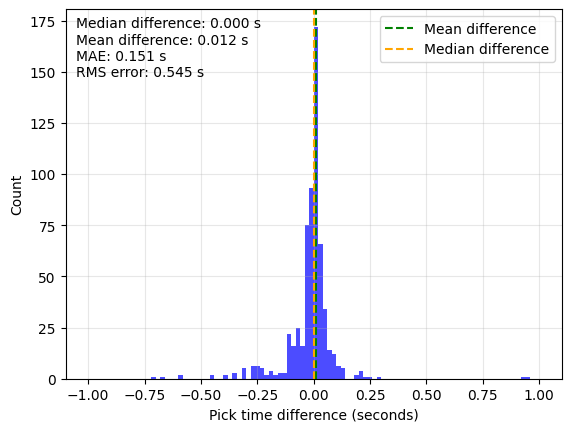

In [3]:
from scipy import ndimage


ComponentOrder = Literal["NPS", "PSN"]

ORDER_MAP: dict[ComponentOrder, tuple[int, int]] = {
    "NPS": (1, 2),
    "PSN": (0, 1),
}


def get_pick_differences(
    predictions: torch.Tensor,
    labels: torch.Tensor,
    order: ComponentOrder = "PSN",
    min_pick_height: float = 0.3,
    window_width: int = 500,
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    label_max, label_pick_sample = labels.max(dim=2)
    label_pick_class = label_max.argmax(dim=1)
    
    p_idx, s_idx = ORDER_MAP[order]
    if window_width:
        epsilon = 1e-10
        labels_numpy = labels.detach().numpy()
        labels_numpy[labels_numpy < epsilon] = 0.0

        window = np.ones(window_width)
        # Expand mask to include neighboring samples
        mask = ndimage.convolve1d(labels_numpy, window, axis=2, mode="constant")
        mask[mask < epsilon] = 0.0
        predictions_masked = predictions * torch.from_numpy(mask.astype(bool))
    else:
        predictions_masked = predictions


    prediction_max, prediction_pick_sample = predictions_masked.max(dim=2)
    # Some samples may not have a pick for P or S wave
    p_mask = label_max[:, p_idx].to(bool)
    s_mask = label_max[:, s_idx].to(bool)

    p_mask &= prediction_max[:, p_idx] >= min_pick_height
    s_mask &= prediction_max[:, s_idx] >= min_pick_height

    p_predicted_picks = prediction_pick_sample[:, p_idx][p_mask]
    p_labeled_picks = label_pick_sample[:, p_idx][p_mask]
    
    p_prob = prediction_max[:, p_idx][p_mask]
    s_prob = prediction_max[:, s_idx][s_mask]

    
    s_predicted_picks = prediction_pick_sample[:, s_idx][s_mask]
    s_labeled_picks = label_pick_sample[:, s_idx][s_mask]
    
    p_labels_binary = label_pick_class[p_mask]
    s_labels_binary = label_pick_class[s_mask]



    return p_predicted_picks, p_labeled_picks, s_predicted_picks, s_labeled_picks, p_prob, s_prob, p_labels_binary, s_labels_binary


p_pred, p_label, s_pred, s_label, final_p_prob, final_s_prob, p_labels_binary, s_labels_binary = get_pick_differences(
    predictions,
    labels,
    order="PSN",
    window_width=500,
)


def plot_histogram(
    predicted: np.ndarray,
    label: np.ndarray,
    sampling_rate: float,
) -> None:
    fig = plt.figure()
    ax = fig.gca()
    offset = (predicted - label) / sampling_rate  # in seconds
    ax.hist(
        offset,
        bins=100,
        range=(-1, 1),
        alpha=0.7,
        color="blue",
    )
    ax.set_xlabel("Pick time difference (seconds)")
    ax.set_ylabel("Count")
    ax.grid(alpha=0.3)

    mean_difference = np.mean(offset)
    median_difference = np.median(offset)
    mean_abs_error = torch.mean(torch.abs(torch.from_numpy(offset)))
    rms_error = np.sqrt(np.mean(offset**2))
    # mean_error = metrics.mean_absolute_error(label, predicted) / sampling_rate

    # ax.axvline(mean_abs_error, color="red", linestyle="dashed", label="Mean offset")
    ax.axvline(
        mean_difference, color="green", linestyle="dashed", label="Mean difference"
    )
    ax.axvline(
        median_difference, color="orange", linestyle="dashed", label="Median difference"
    )


    # TODO: Add fraction which is outside the plotted range
    ax.text(
        0.02,
        0.98,
        f"Median difference: {median_difference:.3f} s\n"
        f"Mean difference: {mean_difference:.3f} s\n"
        f"MAE: {mean_abs_error:.3f} s\n"
        f"RMS error: {rms_error:.3f} s",
        transform=ax.transAxes,
        verticalalignment="top",
    )
    ax.legend(loc="upper right")

    plt.show()


plot_histogram(s_pred.numpy(), s_label.numpy(), sampling_rate=100.0)

In [194]:
type(p_true_label)

torch.Tensor

In [ ]:
p_offset = ((p_pred - p_label)/100).abs()

array([0.        , 0.33333333, 0.66666667, 1.        ])

In [207]:
def calculate_precision_recall_f1(offset: torch.Tensor, time_tolerance = 0.1): 
    
    time_tolerance = 0.1
    thresholds = np.linspace(0, 1, 5)

    precision_list = []
    recall_list = []
    f1_list = []

    for t in thresholds:
        pred_mask = final_p_prob >= t

        TP = (pred_mask & (offset <= time_tolerance)).sum().item()
        FP = (pred_mask & (offset > time_tolerance)).sum().item()
        FN = (~pred_mask).sum().item()

        precision = TP / (TP + FP + 1e-9)
        recall    = TP / (TP + FN + 1e-9)
        f1        = 2 * precision * recall / (precision + recall + 1e-9)


        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
    
    return precision_list, recall_list, f1_list

In [ ]:
def calculate_precision_recall_f1(offset: torch.Tensor, final_prob: torch.Tensor, time_tolerance=0.1) -> dict:
    """Get offset of P and S waves and their corresponding predicted probabilities.

    Args:
        offset (torch.Tensor): offset value of P and S waves.
        final_prob (torch.Tensor): Predicted Masked probabilities around window length.
        time_tolerance (float): Time tolerance mask for offset. Defaults to 0.1.
    Returns:
        dict: Dictionary containing precision, recall, and f1 scores at different thresholds.
        
    """
    thresholds = np.linspace(0, 1, 6)
    thresholds = np.round(thresholds, 2)
    results = {}

    for t in thresholds:
        pred_mask = final_prob >= t
        TP = (pred_mask & (offset <= time_tolerance)).sum().item()
        FP = (pred_mask & (offset > time_tolerance)).sum().item()
        FN = (~pred_mask).sum().item()

        precision = TP / (TP + FP + 1e-9)
        recall    = TP / (TP + FN + 1e-9)
        f1        = 2 * precision * recall / (precision + recall + 1e-9)

        results[t] = {"precision": precision, "recall": recall, "f1": f1}

    return results

In [270]:
def plot_precision_recall_f1(metrics_dict: dict, title):
    """Takes the Metrics dict containing Precision, Recall and F1_score.

    Args:
        metrics_dict (dict): dict containing Precision, Recall and F1_score.
    Returns:
        fig: Matplotlib figure object for further use.
    """
    thresholds = list(metrics_dict.keys())
    precision_list = [metrics_dict[t]["precision"] for t in thresholds]
    recall_list    = [metrics_dict[t]["recall"] for t in thresholds]
    f1_list        = [metrics_dict[t]["f1"] for t in thresholds]

    fig, ax = plt.subplots(figsize=(8,6))

    # Get values at threshold 0.60 for legend
    if 0.60 in thresholds:
        idx = thresholds.index(0.60)
        prec_val = precision_list[idx]
        rec_val  = recall_list[idx]
        f1_val   = f1_list[idx]
    else:
        prec_val = rec_val = f1_val = None

    ax.plot(thresholds, precision_list, label=f"Precision ({prec_val:.2f})" if prec_val else "Precision", linewidth=2, color='blue')
    ax.plot(thresholds, recall_list, label=f"Recall ({rec_val:.2f})" if rec_val else "Recall", linewidth=2, color='orange')
    ax.plot(thresholds, f1_list, label=f"F1 Score ({f1_val:.2f})" if f1_val else "F1 Score", linewidth=2, color='green')
    
    # Mark threshold = 0.60 with a red star
    if 0.60 in thresholds:
        ax.scatter(thresholds[idx], precision_list[idx], color='blue', s=100, marker='*')
        ax.scatter(thresholds[idx], recall_list[idx], color='orange', s=100, marker='*')
        ax.scatter(thresholds[idx], f1_list[idx], color='green', s=100, marker='*')

    ax.set_xlabel("Threshold", fontsize=14)
    ax.set_ylabel("Metric Score", fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    fig.tight_layout()
    plt.show()

    return fig


In [276]:
metrics_dict = calculate_precision_recall_f1(p_offset, final_p_prob, time_tolerance=0.1)



In [278]:
metrics_dict[0.6]

{'precision': 0.9646799116976498,
 'recall': 0.7974452554729974,
 'f1': 0.8731268726296321}

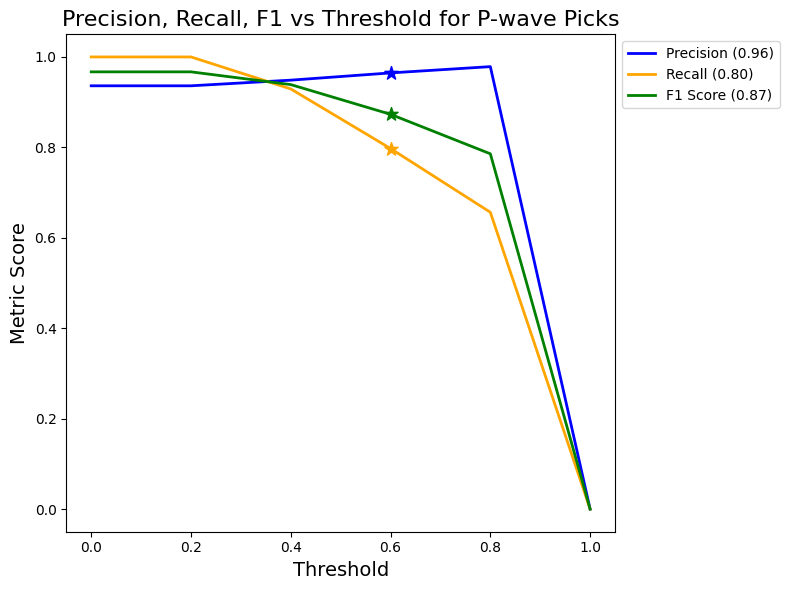

In [274]:
fig = plot_precision_recall_f1(metrics_dict, title="Precision, Recall, F1 vs Threshold for P-wave Picks")

In [230]:
precision_list, recall_list, f1_list = calculate_precision_recall_f1(p_offset)

TypeError: calculate_precision_recall_f1() missing 1 required positional argument: 'final_prob'

In [ ]:
sum(precision_list) / len(precision_list)

0.7620758879795794

In [ ]:
threshold = 0.5  
time_tolerance = 0.3

p_prob_mask = final_p_prob > threshold
s_prob_mask = final_s_prob > threshold

In [5]:
p_offset = ((p_pred - p_label)/100).abs()
s_offset = ((s_pred - s_label)/100).abs()
time_tolerance = 0.3

In [4]:
def calculate_roc_auc(offset: torch.Tensor, final_prob: torch.Tensor, label_binary:torch.Tensor, time_tolerance=0.1) -> float:
    """Calculate ROC AUC score based on offset and predicted probabilities.

    Args:
        offset (torch.Tensor): Offset values of picks.
        final_prob (torch.Tensor): Predicted probabilities.
        time_tolerance (float): Time tolerance for considering a pick as true positive.

    Returns:
        float: ROC AUC score.
    """
    
    y_true_mask = (offset <= time_tolerance)
    phase_label = (label_binary[y_true_mask]==0)
    final_prob_masked = final_prob[y_true_mask]

    tpr, fpr, thresholds = metrics.roc_curve(phase_label.cpu().detach().numpy(),
                                 final_prob_masked.cpu().detach().numpy())
    
    roc_auc = metrics.auc(fpr, tpr)

    return tpr, fpr, roc_auc

In [9]:
tpr, fpr, auc = calculate_roc_auc(p_offset, final_p_prob, p_labels_binary, time_tolerance=0.1)

In [ ]:
p_TP_mask = (p_prob_mask & (p_offset <= time_tolerance))
s_TP_mask = (s_prob_mask & (s_offset <= time_tolerance))


p_FP_mask = (~p_TP_mask)
s_FP_mask = (~s_TP_mask)

In [ ]:
mask_roc_p = (p_offset <= time_tolerance)
masked_prob_p = final_p_prob[mask_roc_p]

In [ ]:
masked_true_label_p = p_labels_binary[mask_roc_p]

In [ ]:
masked_prob_p = final_p_prob[p_TP_mask]

In [ ]:
masked_true_label_p = p_labels_binary[p_TP_mask]

In [ ]:
masked_true_phase_label_p = (masked_true_label_p == 0)

In [ ]:
tpr_p, fpr_p, thresholds = metrics.roc_curve(
    masked_true_phase_label_p.cpu().detach().numpy(), masked_prob_p.cpu().detach().numpy())

In [ ]:
auc_p = metrics.auc(tpr_p, fpr_p)

In [18]:
type(tpr)

numpy.ndarray

In [ ]:
def plot_roc_curve(
    tpr: np.ndarray,
    fpr: np.ndarray,
    auc: float,
    title: str,
) -> FIgure:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(fpr, tpr, linewidth=3, label=f"AUC = {auc:.3f}")

    ax.plot([0, 1], [0, 1], "--", color="gray", linewidth=1)

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("False Positive Rate", fontsize=14)
    ax.set_ylabel("True Positive Rate", fontsize=14)

    ax.tick_params(labelsize=12)
    ax.grid(alpha=0.3)

    ax.legend(
        fontsize=9,
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        borderpad=1,
    )

    fig.tight_layout()
    return fig

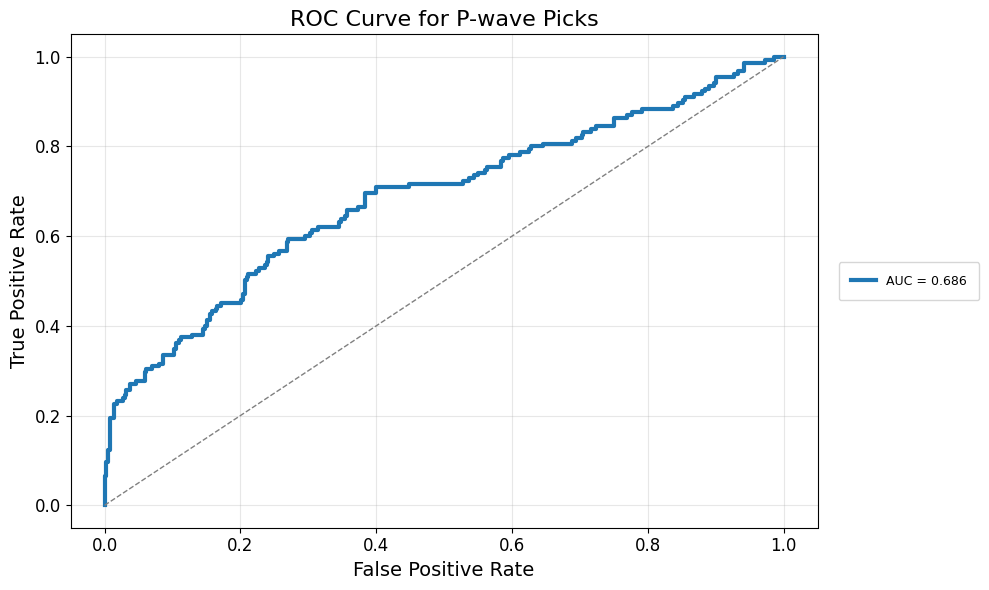

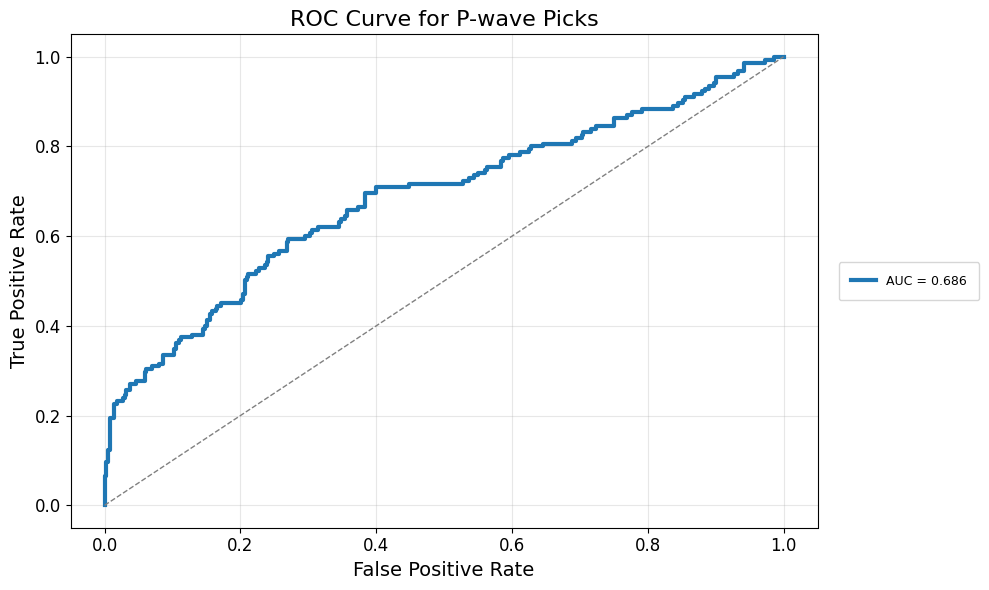

In [25]:
plot_roc_curve(tpr, fpr, title="ROC Curve for P-wave Picks")

In [22]:
fig

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'ROC Curve for P-wave Picks'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

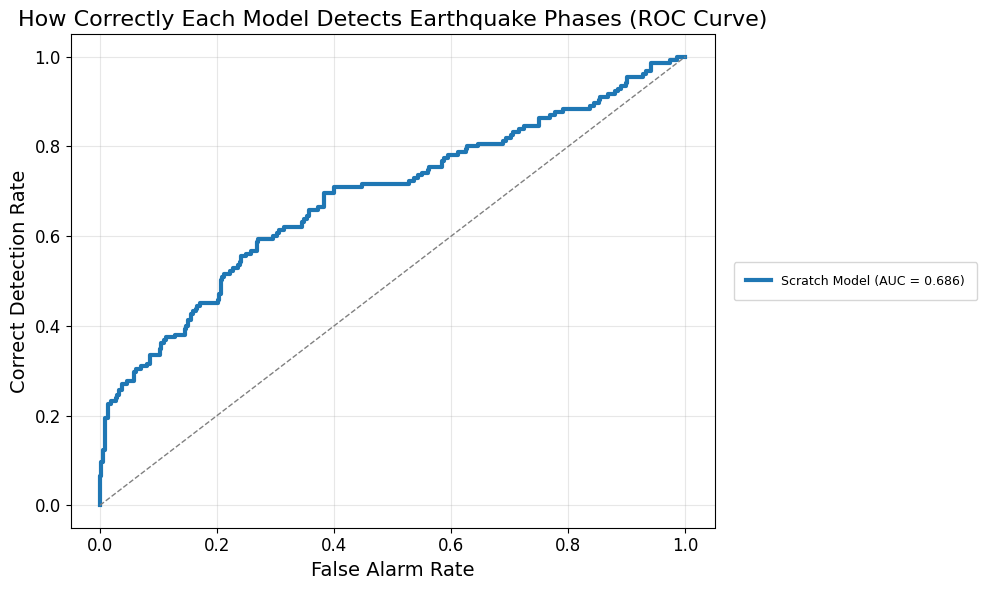

In [17]:
fig = plt.subplots(figsize=(10,6))
plt.plot(fpr, tpr, linewidth=3, label=f"Scratch Model (AUC = {auc:.3f})")

# Random guess diagonal
plt.plot([0, 1], [0, 1], "--", color="gray", linewidth=1)

# Clean labels for non-technical viewers
plt.title("How Correctly Each Model Detects Earthquake Phases (ROC Curve)", fontsize=16)
plt.xlabel("False Alarm Rate", fontsize=14)
plt.ylabel("Correct Detection Rate", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)

# Put legend outside the plot (right side)
plt.legend(
    fontsize=9,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    borderpad=1,
)

plt.tight_layout()
plt.show()

In [ ]:
num_labeled_p = len(p_label)
num_labeled_s = len(s_label)

# predicted picks are only those above prob threshold
p_FN = (~p_prob_mask).sum().item()
s_FN = (~s_prob_mask).sum().item()

In [ ]:
TP_p = p_TP_mask.sum().item()
FP_p = p_FP_mask.sum().item()
FN_p = p_FN

precision_p = TP_p / (TP_p + FP_p + 1e-9)
recall_p    = TP_p / (TP_p + FN_p + 1e-9)
f1_p        = 2 * precision_p * recall_p / (precision_p + recall_p + 1e-9)

In [ ]:
time_tolerance = 0.5

In [ ]:
pred_mask = (p_offset <= time_tolerance)
p_true_label = p_labels_binary[pred_mask] == 0

In [ ]:
phase_label = (p_labels_binary == 0)

In [ ]:
p_prob_final = final_p_prob[pred_mask]

In [ ]:
tpr, fpr, thresholds = metrics.roc_curve(
    phase_label.cpu().detach().numpy(), final_p_prob.cpu().detach().numpy())

In [ ]:
auc_p = metrics.auc(fpr, tpr)

In [ ]:
auc_p

0.656535594035594

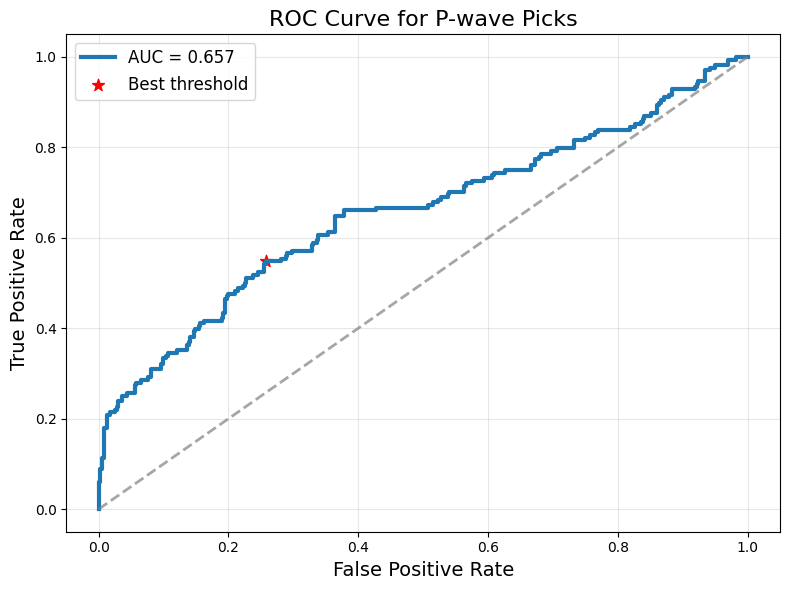

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, linewidth=3, label=f"AUC = {auc_p:.3f}")
plt.plot([0,1],[0,1], '--', linewidth=2, alpha=0.7, color='gray')
plt.scatter(fpr[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)],
            color='red', s=80, marker='*', label='Best threshold')

plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve for P-wave Picks", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
time_tolerance = 0.1
thresholds = np.linspace(0.0, 1, 4)

precision_list_p = []
recall_list_p = []
f1_list_p = []

N = len(final_p_prob)  
for t in thresholds:
    pred_mask = final_p_prob >= t

    TP = (pred_mask & (p_offset <= time_tolerance)).sum().item()
    FP = (pred_mask & (p_offset > time_tolerance)).sum().item()
    FN = (~pred_mask).sum().item()
    # TPR = TP / (TP + FN * 1e-9)
    # FPR = FP / (TP + FP * 1e-9)
    

    precision = TP / (TP + FP + 1e-9)
    recall    = TP / (TP + FN + 1e-9)
    print(precision, recall)
    f1        = 2 * precision * recall / (precision + recall + 1e-9)


    precision_list_p.append(precision)
    recall_list_p.append(recall)
    f1_list_p.append(f1)

0.9361702127642976 0.9999999999981061
0.939999999998291 0.9736346515989197
0.9696969696947093 0.7549909255884665
0.0 0.0


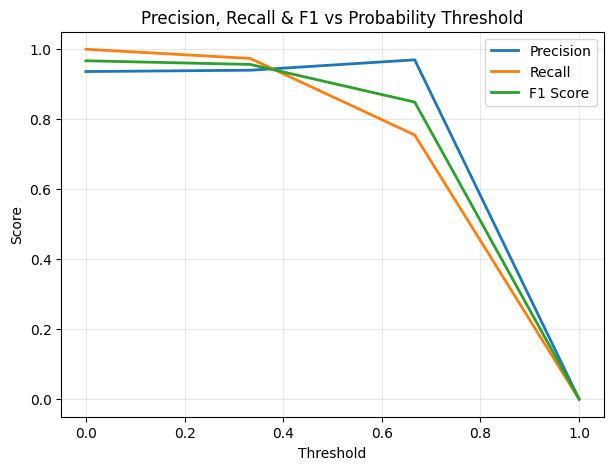

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(thresholds, precision_list_p, label='Precision', linewidth=2)
plt.plot(thresholds, recall_list_p, label='Recall', linewidth=2)
plt.plot(thresholds, f1_list_p, label='F1 Score', linewidth=2)

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall & F1 vs Probability Threshold")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [ ]:
all_offset = torch.cat([p_offset, s_offset])

In [ ]:
tolerances = np.linspace(0, 1, 4)
TPR_list = []
FPR_list = []

total_preds = all_offset.shape[0]

for tol in tolerances:
    # True Positive: offset <= tolerance
    TP_mask = all_offset <= tol
    FP_mask = all_offset > tol
    
    TP = TP_mask.sum().item()
    FP = FP_mask.sum().item()
    
    FN = (~TP_mask).sum().item()  # labeled pick missed
    TN = 0  # optional, or total_negatives - FP if known
    
    TPR = TP / (TP + FN + 1e-8)  # Recall
    FPR = FP / (FP + 1e-8)       # If TN unknown, FPR ~ FP proportion
    
    TPR_list.append(TPR)
    FPR_list.append(FPR)

NameError: name 'all_offset' is not defined

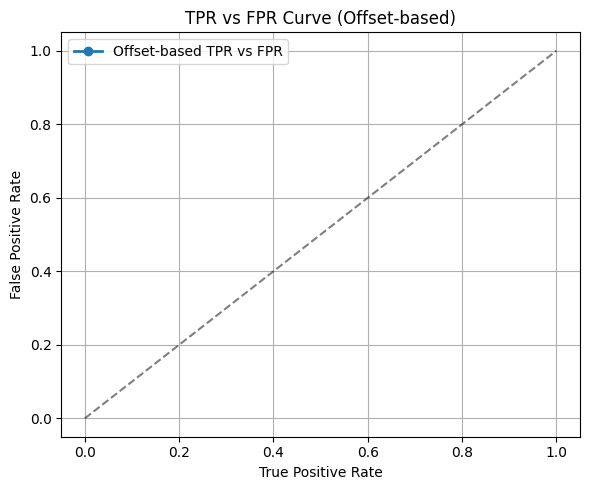

In [ ]:
plt.figure(figsize=(6,5))
plt.plot(TPR_list, FPR_list, marker='o', linewidth=2, label='Offset-based TPR vs FPR')
plt.plot([0,1], [0,1], 'k--', alpha=0.5)
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('TPR vs FPR Curve (Offset-based)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
time_tolerance = 0.1
thresholds = np.linspace(0.0, 0.9, 5)

precision_list_s = []
recall_list_s = []
f1_list_s = []

N = len(final_s_prob)  
for t in thresholds:
    pred_mask = final_s_prob >= t

    TP = (pred_mask & (s_offset <= time_tolerance)).sum().item()
    FP = (pred_mask & (s_offset > time_tolerance)).sum().item()
    FN = (~pred_mask).sum().item()
    TPR = TP / (TP + FN )
    FPR = FP / (TP + FP )

    
    precision = TP / (TP + FP + 1e-9)
    recall    = TP / (TP + FN + 1e-9)
    f1        = 2 * precision * recall / (precision + recall + 1e-9)


    precision_list_s.append(precision)
    recall_list_s.append(recall)
    f1_list_s.append(f1)




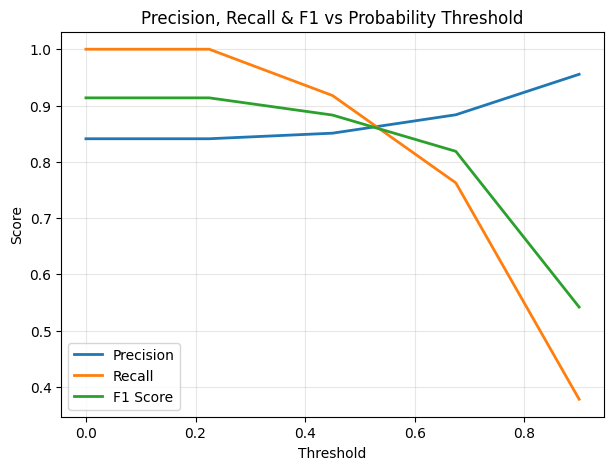

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(thresholds, precision_list_s, label='Precision', linewidth=2)
plt.plot(thresholds, recall_list_s, label='Recall', linewidth=2)
plt.plot(thresholds, f1_list_s, label='F1 Score', linewidth=2)

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall & F1 vs Probability Threshold")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [ ]:
precision_p = p_TP_mask.sum().item() / (p_TP_mask.sum().item() + p_FP_mask.sum().item())
precision_s = s_TP_mask.sum().item() / (s_TP_mask.sum().item() + s_FP_mask.sum().item())

In [ ]:
recall_p = p_TP_mask.sum().item() / (p_TP_mask.sum().item() + p_FN)
f1_score_p = 2 * (precision_p * recall_p) / (precision_p + recall_p)

recall_s = s_TP_mask.sum().item() / (s_TP_mask.sum().item() + s_FN)
f1_score_s = 2 * (precision_s * recall_s) / (precision_s + recall_s)

In [ ]:
print(precision_p)
print(recall_p)
print(f1_score_p)

0.8404255319148937
0.8602540834845736
0.8502242152466368


In [ ]:
print(precision_s)
print(recall_s)
print(f1_score_s)

0.8346456692913385
0.8952702702702703
0.8638956805215974


In [ ]:
# offsets in seconds (or samples)
p_offset = (p_pred - p_label).abs()
s_offset = (s_pred - s_label).abs()

all_offsets = torch.cat([p_offset, s_offset], dim=0)


# labels for “positive pick” based on offset tolerance
time_tolerance = 0.1
all_labels = (all_offsets <= time_tolerance).int()  # 1=TP (within tolerance), 0=FP

In [ ]:
thresholds = np.linspace(0, 1, 50)  # 50 probability thresholds
TPR = []
FPR = []

for thresh in thresholds:
    pred_positive = (all_probs >= thresh).int()
    
    TP = ((pred_positive == 1) & (all_labels == 1)).sum().item()
    FP = ((pred_positive == 1) & (all_labels == 0)).sum().item()
    FN = ((pred_positive == 0) & (all_labels == 1)).sum().item()
    TN = ((pred_positive == 0) & (all_labels == 0)).sum().item()
    
    TPR.append(TP / (TP + FN + 1e-8))  # True Positive Rate = Recall
    FPR.append(FP / (FP + TN + 1e-8))  # False Positive Rate

NameError: name 'all_probs' is not defined

In [ ]:
TPR

[]

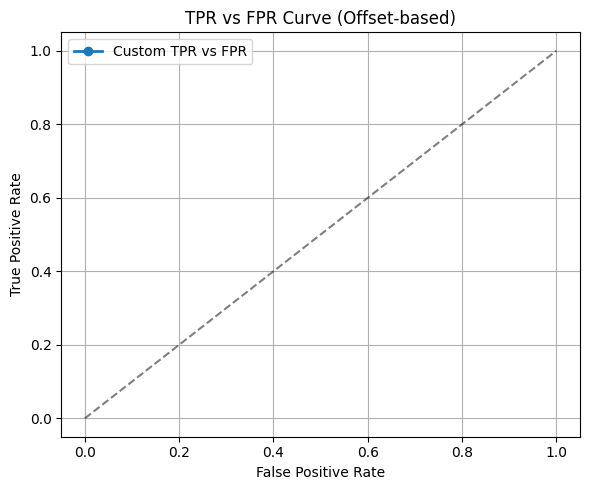

In [ ]:
plt.figure(figsize=(6,5))
plt.plot(FPR, TPR, marker='o', linewidth=2, label='Custom TPR vs FPR')
plt.plot([0,1], [0,1], 'k--', alpha=0.5)  # diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('TPR vs FPR Curve (Offset-based)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_1255788/2549877277.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


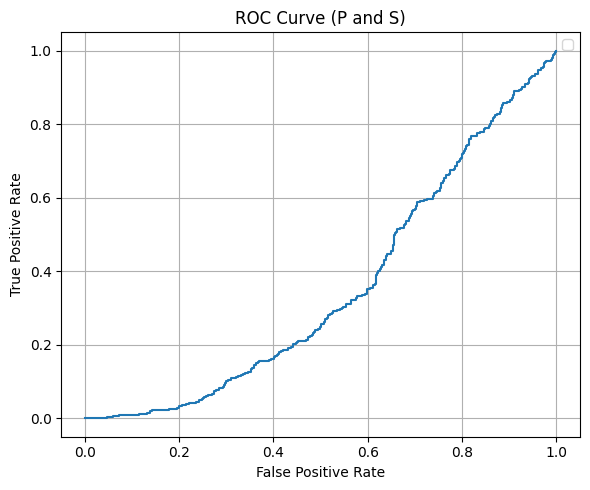

In [ ]:
plt.figure(figsize=(6,5))
plt.plot(fpr_p, tpr_p)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (P and S)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
label_pick_class[p_TP_mask]

IndexError: The shape of the mask [564] at index 0 does not match the shape of the indexed tensor [1024] at index 0

In [ ]:
label_max, label_pick_sample = labels.max(dim=2)
label_pick_class = label_max.argmax(dim=1)   # shape (batch,)

# convert to numpy (for sklearn ROC)
label_pick_class_np = label_pick_class.cpu().numpy()

# convert class index → class name
label_pick_name_np = np.where(label_pick_class_np == 0, "P",
                       np.where(label_pick_class_np == 1, "S", "N"))

# binary P-vs-not-P for ROC input
phase_label_bool_p = (label_pick_class_np == 0)

In [ ]:
p_prob

tensor([0.5382, 0.4094, 0.5314, 0.4322, 0.6680, 0.5898, 0.7989, 0.9105, 0.7501,
        0.6379, 0.5908, 0.6045, 0.7688, 0.5137, 0.5615, 0.7176, 0.7435, 0.4584,
        0.7421, 0.9320, 0.9311, 0.9108, 0.9396, 0.9146, 0.9444, 0.8867, 0.8873,
        0.6806, 0.7208, 0.5388, 0.5812, 0.5869, 0.8453, 0.3280, 0.8631, 0.8911,
        0.6616, 0.9010, 0.8916, 0.9177, 0.9133, 0.3963, 0.4047, 0.3290, 0.3990,
        0.5137, 0.4696, 0.9443, 0.8315, 0.8857, 0.9538, 0.5819, 0.7875, 0.9543,
        0.9184, 0.3791, 0.9368, 0.8677, 0.9255, 0.8078, 0.9431, 0.9536, 0.9565,
        0.9380, 0.9483, 0.9400, 0.9328, 0.9394, 0.9302, 0.3526, 0.3307, 0.9016,
        0.9513, 0.9448, 0.9404, 0.8828, 0.9129, 0.9208, 0.8968, 0.7668, 0.5403,
        0.7391, 0.9408, 0.5232, 0.8527, 0.9439, 0.9102, 0.9706, 0.9647, 0.9334,
        0.9469, 0.9105, 0.9511, 0.9228, 0.9668, 0.7892, 0.9248, 0.7510, 0.9052,
        0.8699, 0.9142, 0.7928, 0.9338, 0.4481, 0.9643, 0.9310, 0.9619, 0.9544,
        0.9012, 0.8589, 0.9334, 0.8718, 

In [ ]:
scores = torch.cat([p_prob, s_prob])

In [ ]:
y_true_p = torch.cat([
    torch.ones_like(p_label),   
    torch.zeros_like(s_label)  
])

In [ ]:
y_true_p.shape

torch.Size([1199])

In [ ]:
label_pick_name_np = np.where(y_true_p == 0, "P",
                       np.where(y_true_p == 1, "S", "N"))

# binary P-vs-not-P for ROC input
phase_label_bool_p = (label_pick_class_np == 0)

In [ ]:
phase_label_bool_p

array([False,  True,  True, ..., False,  True, False], shape=(1024,))

In [ ]:
fpr_p, tpr_p, _ = metrics.roc_curve(phase_label_bool_p, scores.cpu().detach().numpy())
auc_p = metrics.auc(fpr_p, tpr_p)


ValueError: Found input variables with inconsistent numbers of samples: [1024, 1199]

In [ ]:
auc_p

0.5433573462891607

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(phase_label_bool_p, score_p.cpu().detach().numpy())
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  name='example estimator')

ValueError: Found input variables with inconsistent numbers of samples: [1024, 564]

In [ ]:
from matplotlib.figure import Figure
def plot_roc_curve(
    scores: np.ndarray,
    labels: np.ndarray,
    title: str = "Roc Curve",
    show_figure: bool = False
) -> Figure | None:
    """
    Plot a (smooth) ROC curve for binary classification (P vs non-P).

    Parameters
    ----------
    scores : np.ndarray
        Continuous classifier scores (higher = stronger P probability).
    labels : np.ndarray
        Binary labels (1 = P, 0 = non-P).
    title : str
        Plot title.
    show_figure : bool
        If True, display the figure.
    smooth : bool
        Whether to apply Savitzky–Golay smoothing to the ROC curve.

    Returns
    -------
    fig : Figure
        The matplotlib figure.
    """

    # Compute ROC
    fpr, tpr, thresholds = metrics.roc_curve(labels, scores)
    roc_auc = metrics.auc(fpr, tpr)

    # Create figure
    fig = plt.figure()
    ax = fig.gca()

    # ROC curve
    ax.plot(fpr, tpr, linewidth=2.0, label=f"AUC = {roc_auc:.3f}")
    ax.plot([0, 1], [0, 1], "--", linewidth=1.0, alpha=0.6)

    # Labels
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title)
    ax.grid(alpha=0.3)
    ax.legend(loc="lower right")
    if show_figure:
        plt.show()
    return tpr, fpr, fig

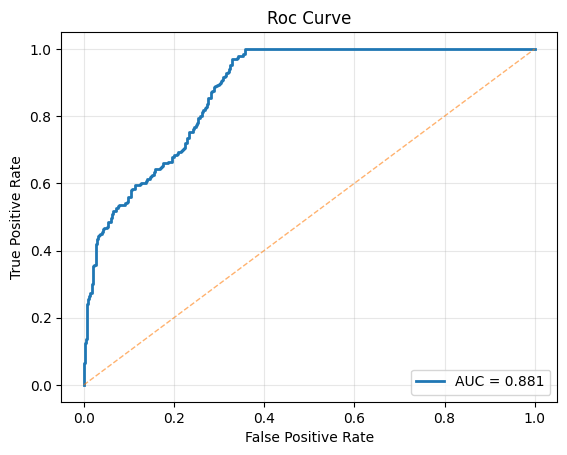

In [ ]:
tpr, fpr, plot = plot_roc_curve(score_p_or_s.detach().numpy(), phase_label_bool, show_figure=False)

In [ ]:
type(tpr)

numpy.ndarray

Text(0, 0.5, 'true positive rate')

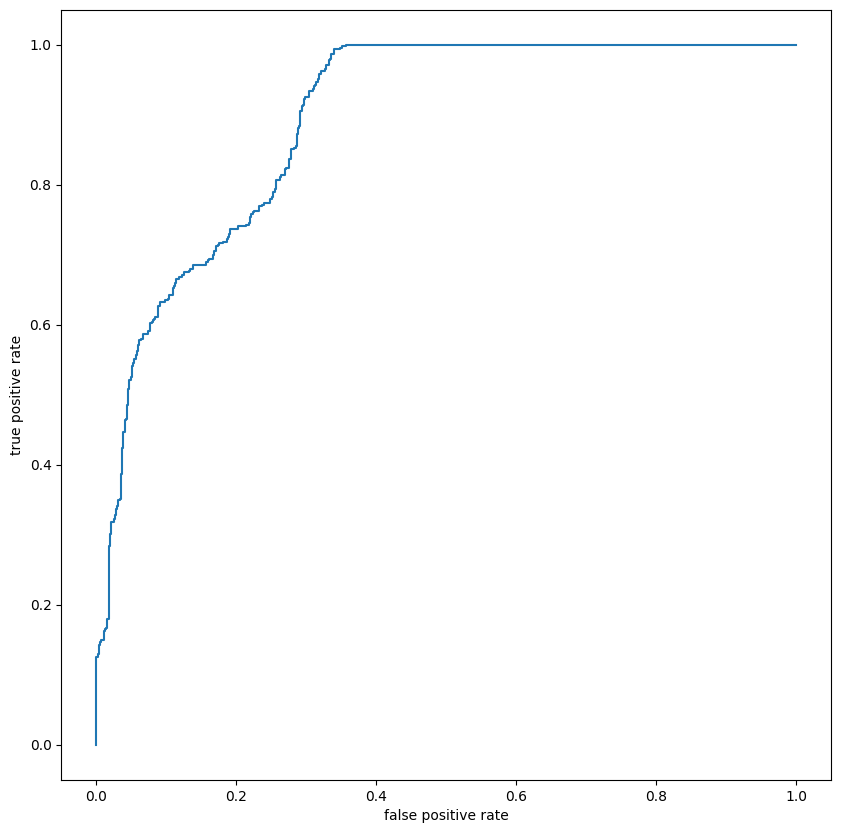

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(fpr, tpr)
ax.set_aspect("equal")

ax.set_xlabel("false positive rate")
ax.set_ylabel("true positive rate")

np.float64(1.0)

In [ ]:
torch.mean(torch.abs(torch.from_numpy(offset)))

tensor(0.1156, dtype=torch.float64)

In [ ]:
y_true = (p_label).numpy()
y_pred = (p_pred).numpy()
sampling_rate = 100  # Hz → each sample = 0.01 s
time_per_sample = 1 / sampling_rate

rmse_samples = metrics.mean_absolute_error(y_true, y_pred)
rmse_seconds = rmse_samples * time_per_sample

Difference in samples: 5
tensor(True)


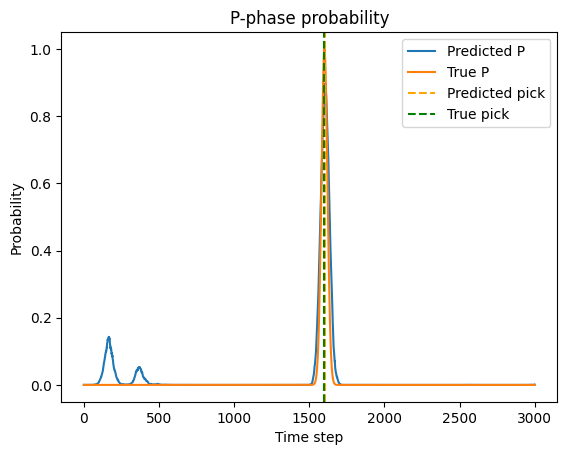

In [ ]:
sample = 149
channel = 0  # P-wave channel
prediction_max, prediction_pick_sample = predictions.max(dim=2)
label_max, label_pick_sample = labels.max(dim=2)


pred_sample = prediction_pick_sample[sample, channel]
labled_sample = label_pick_sample[sample, channel]
print(f"Difference in samples: {pred_sample - labled_sample}")
print(labled_sample.to(bool))

plt.plot(predictions[sample, channel, :].detach(), label="Predicted P")
plt.plot(labels[sample, channel, :].detach(), label="True P")
plt.axvline(x=pred_sample, color="orange", linestyle="--", label="Predicted pick")
plt.axvline(x=labled_sample, color="green", linestyle="--", label="True pick")
plt.xlabel("Time step")
plt.ylabel("Probability")
plt.title("P-phase probability")
plt.legend()
plt.show()


In [ ]:
single_trace_p_predictions[1]

array([1.3888569e-04, 7.5464814e-05, 5.9859762e-05, ..., 1.2004931e-03,
       1.0576312e-03, 1.6171911e-03], shape=(3001,), dtype=float32)

In [ ]:
#    We need to find the peaks that exceed a threshold (e.g., 0.5)
threshold = 0.5 
peak_indices, _ = find_peaks(single_trace_p_predictions, height=threshold)

# 3. Reshape the list of indices into the (n, 1) format for KDTree
#    The number of points (n) is the number of picks found. The dimension (m) is 1 (time).
if peak_indices.size > 0:
    T_model = peak_indices.reshape(-1, 1)
    
    # Corrected KDTree call
    model_tree = KDTree(T_model)
    # The KDTree is now correctly built from shape (n_picks, 1)
else:
    # Handle case with no predictions
    print("No model picks found above the threshold for this trace.")

No model picks found above the threshold for this trace.


Text(0, 0.5, 'true positive rate')

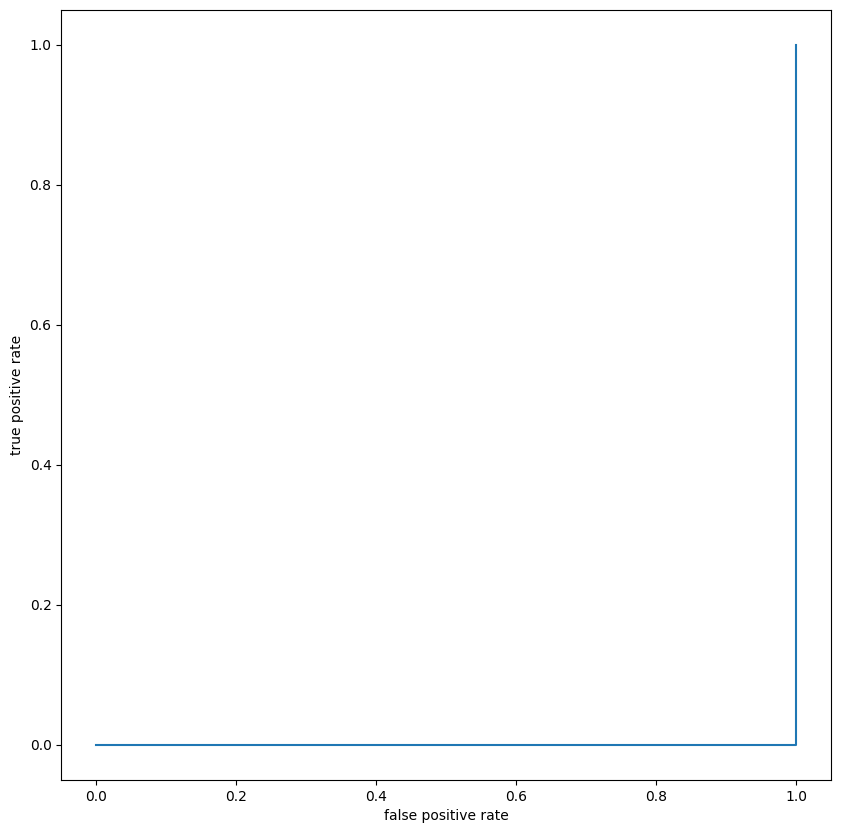

In [ ]:
from typing import NamedTuple

from sklearn.metrics import roc_curve


class PickScores(NamedTuple):
    p_prob: np.ndarray
    s_prob: np.ndarray
    p_label: np.ndarray
    s_label: np.ndarray


def get_pick_score(
    predictions: torch.Tensor,
    labels: torch.Tensor,
    order: ComponentOrder = "PSN",
) -> PickScores:
    label_max, label_argmax = labels.max(dim=2)

    p_idx, s_idx = ORDER_MAP[order]

    # Some samples may not have a pick for P or S wave
    p_mask = label_max[:, p_idx].to(bool)
    s_mask = label_max[:, s_idx].to(bool)

    label_argmax_p = label_argmax[:, p_idx]
    label_argmax_s = label_argmax[:, s_idx]

    p_predicted_probability = predictions[:, p_idx, :].gather(1, label_argmax_p.unsqueeze(1)).squeeze(1)[p_mask]
    s_predicted_probability = predictions[:, s_idx, :].gather(1, label_argmax_s.unsqueeze(1)).squeeze(1)[s_mask]
    # p_predicted_probability = predictions[label_argmax][p_mask]
    # s_predicted_probability = -predictions[:, s_idx, label_argmax][s_mask]
    p_prob = p_predicted_probability.detach().numpy()
    s_prob = 1 / s_predicted_probability.detach().numpy()

    p_label = np.ones_like(p_prob)
    s_label = -np.zeros_like(s_prob)

    return PickScores(
        p_prob.ravel(),
        s_prob.ravel(),
        p_label.ravel(),
        s_label.ravel(),
    )

res = get_pick_score(predictions, labels)
fpr, tpr, _ = roc_curve(np.concatenate((res.p_label, res.s_label)), np.concatenate((res.p_prob, res.s_prob)))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(fpr, tpr)
ax.set_aspect("equal")

ax.set_xlabel("false positive rate")
ax.set_ylabel("true positive rate")

In [ ]:
res

PickScores(p_prob=array([5.38158238e-01, 4.06785488e-01, 5.30986369e-01, 6.68528736e-01,
       4.20144899e-03, 4.09999251e-01, 3.98389548e-01, 4.32236791e-01,
       2.46011391e-01, 6.66603804e-01, 3.74580443e-01, 5.66235244e-01,
       2.41727546e-01, 7.91086614e-01, 9.10463393e-01, 7.48775482e-01,
       6.35633528e-01, 5.83035946e-01, 5.92645347e-01, 7.61047661e-01,
       5.13680995e-01, 5.50328791e-01, 7.16798782e-01, 7.40544260e-01,
       1.86127261e-03, 4.53487784e-01, 7.36757040e-01, 9.29591119e-01,
       9.31085765e-01, 9.09098268e-01, 9.36328888e-01, 8.80895197e-01,
       9.44426835e-01, 8.84119749e-01, 8.83381844e-01, 6.77668154e-01,
       7.13698626e-01, 5.35483062e-01, 5.73323429e-01, 5.82734942e-01,
       2.91168690e-02, 8.45306933e-01, 9.25809960e-04, 3.28019351e-01,
       6.36697039e-02, 8.52110326e-01, 8.91061902e-01, 6.54360890e-01,
       8.97619009e-01, 8.86694133e-01, 9.17392552e-01, 9.06664014e-01,
       1.93953872e-01, 1.46582112e-01, 1.63593009e-01, 1.97